#Radiometer Experiment 1 - Calibration and normal radiometer operation

## Experimental setup

<img src="https://lh5.googleusercontent.com/-MQnV1zYcQWA/VKmzjJYKqYI/AAAAAAAB84E/1qX4x5rKVAQ/w977-h733-no/20150104_154121.jpg" alt="LabSetup" style="width: 400px;"/>

Experiment 1 is used to help us establish that we can look at different physical temperatures that are calibrated to the radiometer.  For this experiment we use both the Software Defined Radio running GNURadio with the radiometer firmware and a square-law detector that is connected to a data aquisition unit.  The experiment uses a 50 ohm matched load that is attached to the radiometer.  This matched load is then submerged into three different baths, a Liquid Nitrogen at ~ 77 K, Ice bath at ~ 273.15 K and hot water water at 341.15 K.   It is also used to verify that the software defined radio does in fact behave in the same manor as the square-law detector and to verify it's operation as a total power radiometer in comparison to a more traditional radiometer which uses a square-law detector.

##Software Defined Radio Setup
The Software Defined Radio uses a N200 SDR from Ettus Research with GNURadio running a custom code for performing as a radiometer.  This program includes a GUI that allows for us to monitor the radiometer as well as control many of the properties of the radiometer such as frequency, bandwidth and integration time.  
<img src="https://lh6.googleusercontent.com/-8X3Tm3wyh-k/U-mZk_99UcI/AAAAAAAB5Vk/-Up_76efr7E/w1214-h759-no/Lab_0_Spectrum.png" alt="SDR" width=100%>

The program stores the total power data as a binary format which we can then load into a program such as Matlab or Python.  While we can also store the raw I/Q values as well, this results in data files that can be easily 20-40 GB in size for typical 10-15 minute experimental run.  The total power binary files are much smaller (usually less than 200 kB) and make it much easier to use.

The following table shows the configuration of the software defined radio and square-law detector.  This information is important as it let's us know the frequency, bandwidth and integration time.  We can use this information to calculate what the $NE\Delta T$ should be.

|Device  |Frequency  |Bandwidth  |Integration time
|--------|-----------------------
|N200    | 1406 MHz    |10 MHz or Msps| 2 seconds
|$X^2$   | NA    |25 MHz  | NA

The square-law detector does not have a frequency since it does not have a local mixer or demodulator.  It also does not have an integrator as well.  However, as we will soon see we do integrate the square-law data by running it through a low pass filter.  The bandwidth of the square-law detector is controlled by the bandpass filters that we are using on the RF front end.  For the SDR, we can control both frequency and bandwidth and in software we do have an integrator.  While the SDR can go as high as 25 MHz or 25 Msps, the current computer we are using was not able to keep up with that bandwidth.  Overflow errors would begin shortly after the experiment began which means that we are losing information.  Therefore we kept the SDR at 10 MHz.  As we will see soon, this does mean that technically the square-law detector does have a better $NE\Delta T$ compared to the SDR due the fact that it sees the full 25 MHz bandwidth.

## Square-law detector
The square-law detector is connected to a NI-USB6000 DAQ system.  This records the analog voltage sent from the square-law detector.  A LabView program then receives this data and stores the data in a ASCII CSV file.  

<img src="https://lh5.googleusercontent.com/-sLn6266TiCs/U-mZpQ2LFfI/AAAAAAAB5Vs/eV8G_uUIQeU/w1402-h759-no/labviewx2_lab0.png" alt="X2" width=100%>

The Labview program allows us to to record and monitor the data the square-law detector is receiving.  Unlike the SDR though, there is no other parameters that we can control.  The square-law detector is at the mercy of the RF front end that we are using.
- - -

#Analysis using Python
Let's begin our analysis.  We will use Python to load the data files, parse them, analyse the data and graph the data.  All of this will take place within this iPython notebook.  

We begin with setting up our environment and importing required libraries.  Scipy allows us to read in the binary data files that GNURadio uses.  Numpy gives us access to a number of useful tools including graphing.  The csv module allows us to read in and parse comma seperated files.  These files are the calibration file and the square-law data is also stored as a CSV file.

Finally we have a module that allows us to colorize the plots based on various parameters.  

For the slideshow, we will skip most of the Python code used, however we will highlight certain key code segments.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import numpy
import scipy.io as sio
import csv
import matplotlib.image as mpimg

import colorline
colorline = colorline.colorline

from scipy.interpolate import interp1d

Before we begin, let's look at what we expect our performance to be.  This is our $NE\Delta T$ equation and the equations is below.

(1)  $$NE\Delta T=\frac{T_{A}+T_{sys}}{\sqrt{\beta  \tau}}$$

We will assume that our $T_{sys}$ is 400 Kelvin, which is based on information provided by the University of Michigan for the RF front we are using that they constructed. $T_{A}$ is our antenna temperature but we are not using an antenna for these experiments.  Instead our $T_{A}$ will be the same temperature that our matched is which will be based on the physical temperature of the matched load.  $\beta$ is our bandwidth, which for the SDR is 10 MHz and for the square-law is 25 MHz.  Finally $\tau$ is our integration time, which we will use 2 seconds.  Let's plug these in and calculate for each device.

In [3]:
tau = 2
BSDR = 10e6
BX2 = 25e6
Tsys = 350
TA = 77

In [4]:
NEAT_SDR = (TA + Tsys)/sqrt(BSDR*tau)
NEAT_X2 = (TA + Tsys)/sqrt(BX2*tau)

In [5]:
print NEAT_SDR
print NEAT_X2

0.0954801026392
0.0603869191133


Our $NE\Delta T$ is pretty good.  Ideally we want our $NE\Delta T$ below 1 Kelvin.  The SDR is currently at .0939 Kelvin and the square-law is .0594 Kelvin.  It should be noted that this equation is simplified.  We do have other factors that while their contribution is small, still adds to our $NE\Delta T$.  Items such as the mixer and LNA on the SDR, quantization noise from the analog to digital converters in both the SDR and square-law, and some other noise sources not taken into affect will change this.  However this does give us a good approximation and let's us know that the integration time and bandwidth is adequate for our needs.

To make it easier to refer to, we will set the file names to a variable we can use later.  These files are stored in the same folder as this iPython script.

In [6]:
tpr = 'SDR_TPR_EXP1.dat'
calib = 'calib.csv'
x2_data = 'x2data_EXP1_ASCII.csv'

The following reads in the binary file produced by GNURadio.  This stores it into an array that Python can work with.

In [7]:
f = scipy.fromfile(open(tpr),dtype=scipy.float32)

Because of the valve function in GNURadio, there are zeros that get added to the file, usually at the beginning.  We do not need or want these as it means we did not start recording yet.  This will trim out the zeros and make working with the data easier.

In [8]:
f = numpy.trim_zeros(f)

Create an index array for plotting.  Also, since we know the interval the data is taken, we can convert this to an actual time.  This now gives us a time scale in our graphs.

In [9]:
timedata = numpy.linspace(0,(len(f)*.49),numpy.size(f))

## Plot the data
Let's begin by plotting the data from the Software defined radio.  The total power readings we get from the software defined radio are technically unitless because they are not calibrated to anything.  However, for convience we will refer to these as rQ values which carry no units.  As stated earlier, we also have a time index that will be in seconds.

Since we are interested in using these in my thesis, we will also configure matplotlib to use the $\LaTeX$ compiler so the graphs will insert nicely into the thesis.

In [10]:
matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})

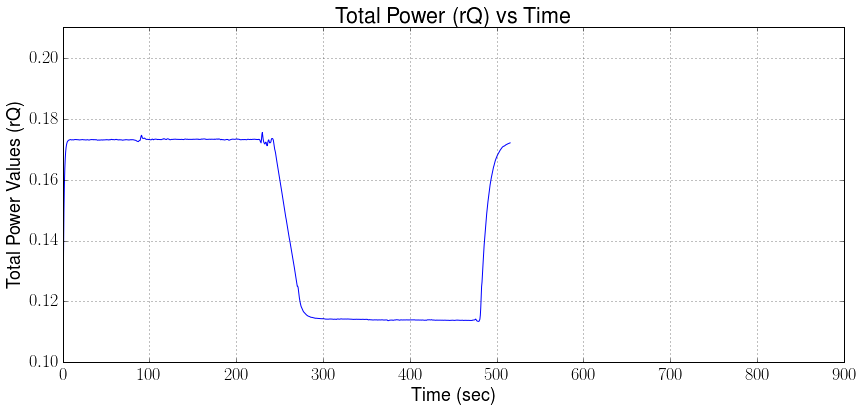

In [11]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(timedata,f)
xlabel('Time (sec)')
ylabel('Total Power Values (rQ)')
title('Total Power (rQ) vs Time')
axis([0, 900, .1, .21])
grid(True)
fig.savefig("rqvstime.pdf", dpi=300)
fig.savefig("rqvstime.png", dpi=300)

Let's talk about this experiment.  Here we have a matched load that starts in an ice water bath and is measured to be approximatly -1.5 C or 271.65 K.  Next we placed the matched load into a LN2 bath.  This reduces the temperature to approximatly 77 K.  Finally we place the load into hot water measured at approximatly 353 K.  Let's highlight each stage below.  

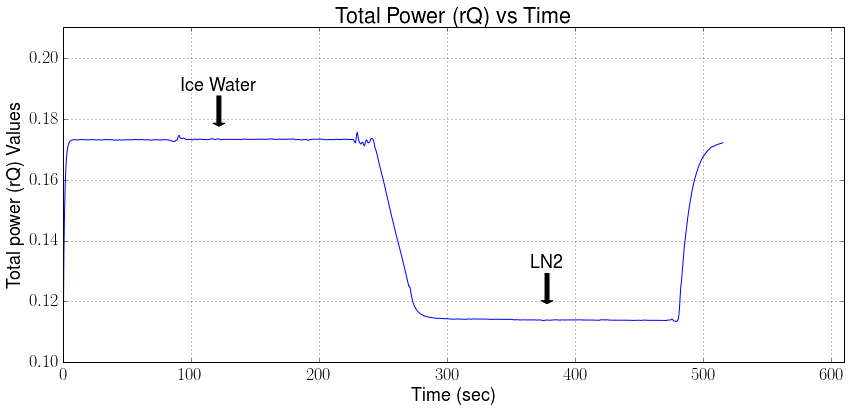

In [12]:
fig = plt.figure(figsize=(14,6), dpi=300)
ax = fig.add_subplot(111)
plot(timedata,f)
xlabel('Time (sec)')
ylabel('Total power (rQ) Values')
title('Total Power (rQ) vs Time')
axis([0, 610, .1, .21])
grid(True)
ax.annotate('Ice Water', xy=(.20, .7),  xycoords='axes fraction',
                xytext=(0.20, 0.85), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='top',
                )
ax.annotate('LN2', xy=(.62, .17),  xycoords='axes fraction',
                xytext=(0.62, 0.32), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='top',
                )
# ax.annotate('Hot Water', xy=(.8, .9),  xycoords='axes fraction',
#                xytext=(0.8, 0.75), textcoords='axes fraction',
#                arrowprops=dict(facecolor='black', shrink=0.05),
#                horizontalalignment='center', verticalalignment='top',
#                )
fig.savefig("rqvstime_annotate.pdf", dpi=300)
fig.savefig("rqvstime_annotate.png", dpi=300)

For the rest of the experiment we will focus on the transition from ice water to LN2 and back.

## Calibration

The rQ values are the raw values from the total power radiometer and are uncalibrated.  While the graph shows the change in the total power recorded and shows that the radiometer can detect changes in noise temperature, it has no other meaning than that.  What we want is to show what the total power is in relation to a noise temperature.  Since we have recorded the values of the rQ at fixed and known teperatures, we can create a calibration line and calibrate the radiometer.  For this experiment, we found that the following values matched our two known temperatures.

|rQ Value|X^2 Voltage|Temperature
|--------|-----------------------
|.1139   | 1.9846    |77 K
|.1730   | 2.1065    |271.65 K

We can now solve for y = mx + b since we have two equations and two unknowns.

To work with this, a calibration file is created.  This is a very simple CSV file that contains 3 values: The raw rQ value, the raw voltage from the square-law detector (discussed later) and the observed temperature.  The table above would then look like the following in the file.
```
.1139,1.9846,77
.1730,2.1065,271.65
```
- - -

It should be noted that from here on out we will just use the LN2 and and ice water bath for our two points.  Because the square-law detector and the SDR have different sensitivities, it will mean that there will be an error when it goes outside of the calibration points.  Multiple points could be used, but traditionally we calibrate a radiometer to just two known points.  

We need to read in the values from our CSV file that contains the values

In [13]:
read_csv = open(calib, 'rb')
csvread = csv.reader(read_csv)
rQ_values = []
temp_values = []
voltage = []

for row in csvread:
    rQ,volt,temp = row
    rQ_values.append(float(rQ))
    voltage.append(float(volt))
    temp_values.append(float(temp))
read_csv.close()

Once we have our data points, we just do a simple linear algebra to solve for the two unknowns, this is quite easy to do with NumPy.

In [14]:
a = numpy.array([[rQ_values[0],1.0],[rQ_values[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [15]:
z = numpy.linalg.solve(a,b)
print z

[ 3293.57052091  -298.13767695]


Let's now plot this line, this line is our calibration line for this particular data set.

In [16]:
fig = plt.figure(figsize=(14,6), dpi=300)


Now we apply these values to the array that holds our raw rQ values

In [17]:
sdrdata = f*z[0]+z[1]

Now we can re-plot the graph but this time with the calibrated noise temperatures.  We can also colorize it as well to show the noise temperatures.  

In [18]:
m = interp1d([70,375],[0,1])
g = sdrdata[(4*2):]
y = timedata[(4*2):]

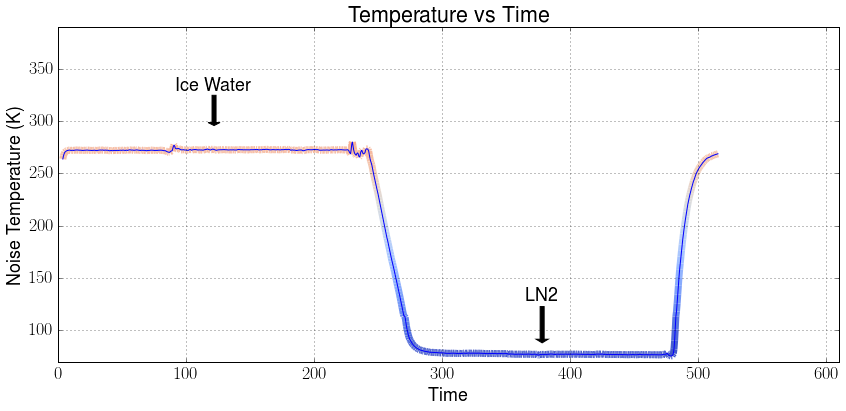

In [19]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,g)
colorline(y,g,m(g),linewidth=7,cmap='coolwarm')
xlabel('Time')
ylabel('Noise Temperature (K)')
title('Temperature vs Time')
grid(True)
axis([0, 610, 70, 390])
plt.annotate('Ice Water', xy=(.20, .7),  xycoords='axes fraction',
                xytext=(0.20, 0.85), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='top',
                )
plt.annotate('LN2', xy=(.62, .05),  xycoords='axes fraction',
                xytext=(0.62, 0.22), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='top',
                )
#plt.annotate('Hot Water', xy=(.8, .9),  xycoords='axes fraction',
#                xytext=(0.8, 0.75), textcoords='axes fraction',
#                arrowprops=dict(facecolor='black', shrink=0.05),
#                horizontalalignment='center', verticalalignment='top',
#                )
fig.savefig("sdr_calibrated_color.pdf", dpi=300)
fig.savefig("sdr_calibrated_color.png", dpi=300)

- - -
# Square-law data

We now want to look at the data from the Square-Law detector to verify the operation of the SDR.  In the experiment that was conducted above, a power splitter was used to split the RF signal so that one went to the SDR and the other to a square-law detector (with a 3.1 dB loss though).  Therefore both data should be the same.  Let's read and then plot this data.

In [20]:
read_csv = open(x2_data, 'rb')
csvread = csv.reader(read_csv)
dummy = []
x2_voltage = []

for row in csvread:
    dummy,x2voltage = row    
    x2_voltage.append(float(x2voltage))
read_csv.close()

Like the SDR data, we want to have a time reference at the bottom.

In [21]:
w = numpy.linspace(0,(len(x2_voltage)*.01),numpy.size(x2_voltage))

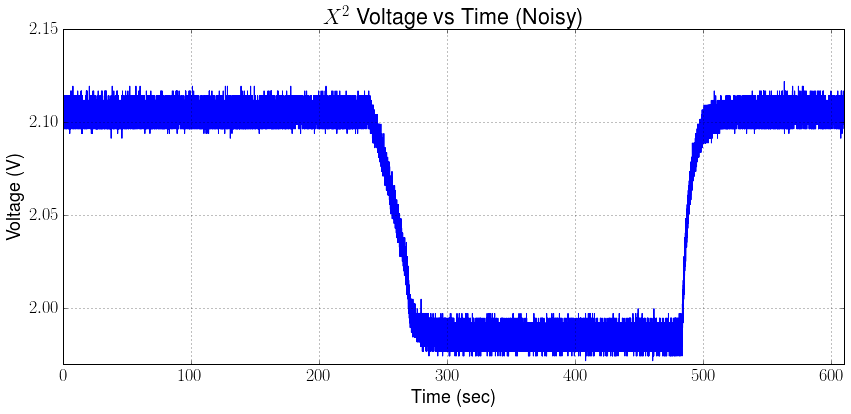

In [22]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_voltage)
xlabel('Time (sec)')
ylabel('Voltage (V)')
title('$X^2$ Voltage vs Time (Noisy)')
axis([0, 610, 1.97, 2.15])
grid(True)
fig.savefig("noisy_voltage.pdf", dpi=300)
fig.savefig("noisy_voltage.png", dpi=300)

Unlike the software defined radio, we do not have an integrator or low pass filter and so the data is very noisy have a filter on it unlike the data we get from the SDR.  We therefore want to apply a filter to to this square-law detector data to help clean it up.

Using Scipy, we can use the signal processing tools to generate a low pass filter and then apply it to the data we have.  Once again, python makes this very easy to implement and use.

In [23]:
from scipy import signal
N=100
Fc=40
Fs=1600
h=scipy.signal.firwin(numtaps=N, cutoff=Fc, nyq=Fs/2)
x2_filt=scipy.signal.lfilter(h,1.0,x2_voltage)

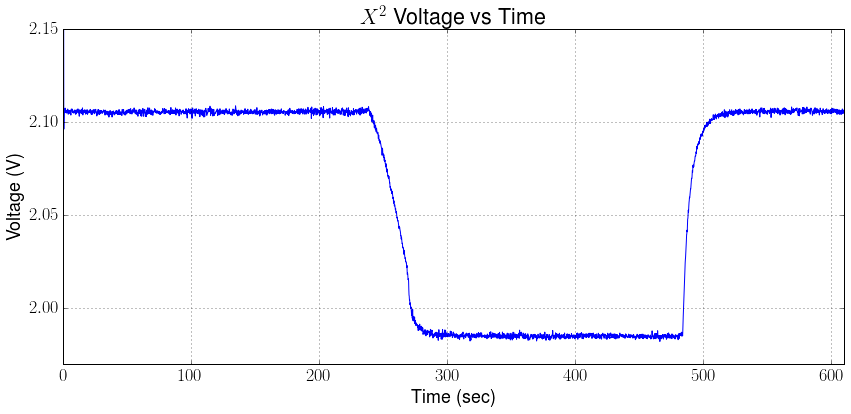

In [24]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_filt)
xlabel('Time (sec)')
ylabel('Voltage (V)')
title('$X^2$ Voltage vs Time')
axis([0, 610, 1.97, 2.15])
grid(True)
fig.savefig("x2_filter.pdf", dpi=300)
fig.savefig("x2_filter.png", dpi=300)

Our data is better, but it is not as good as the SDR data for a couple of reasons.  The SDR data goes through an integrator and then is also decimated or is essentially run through a low pass filter.  This process removes a lot of the noise we would normally see in the signal.  However, for our graphing purposes, this will work.

Now we wish to calibrate this data as well.  We will use the same file and use the calibration points in that file.

In [25]:
a = numpy.array([[voltage[0],1.0],[voltage[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [26]:
z = numpy.linalg.solve(a,b)
print z

[ 1596.80114848 -3092.01147612]


In [27]:
x2_calib = x2_filt*z[0]+z[1]

Now let us plot the data again, but now with it calibrated.

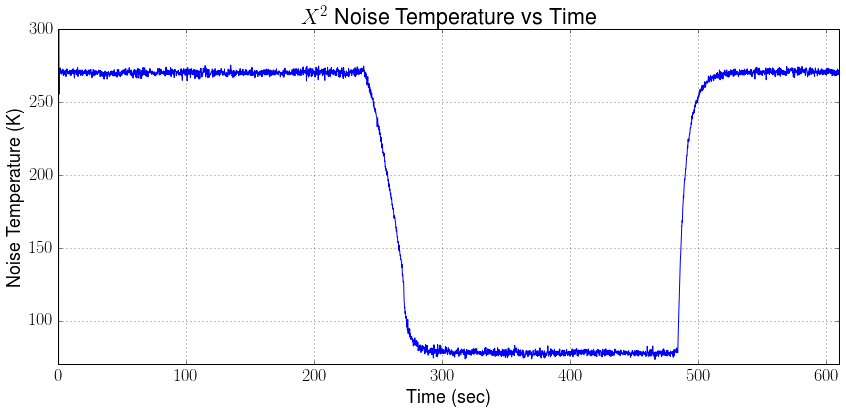

In [28]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_calib)
xlabel('Time (sec)')
ylabel('Noise Temperature (K)')
title('$X^2$ Noise Temperature vs Time')
axis([0, 610, 70, 300])
grid(True)
fig.savefig("x2_calibrated.pdf", dpi=300)
fig.savefig("x2_calibrated.png", dpi=300)

This looks to be the same as our SDR graph, but let's overlay them to make sure

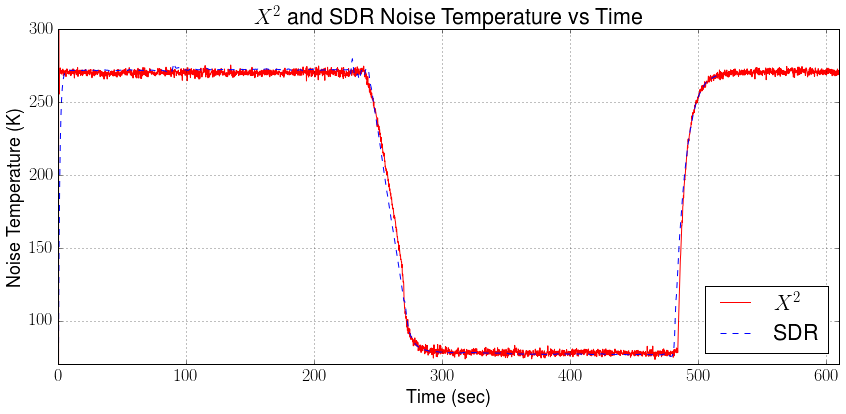

In [29]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_calib,'r',label='$X^2$')
plot(timedata,sdrdata,'b--',label='SDR')
xlabel('Time (sec)')
ylabel('Noise Temperature (K)')
title('$X^2$ and SDR Noise Temperature vs Time')
axis([0, 610, 70, 300])
grid(True)
legend(loc='lower right')
fig.savefig("x2_SDR_Calibrated.pdf", dpi=300)
fig.savefig("x2_SDR_Calibrated.png", dpi=300)

We have some timeshift due to two reasons.  One, the timing isn't always perfect when starting the collection of the two data sets.  And two, we get a timeshift from both the filters used and the integrator.  I have attempted to match them up as best as I can, but some differences are to be expected.

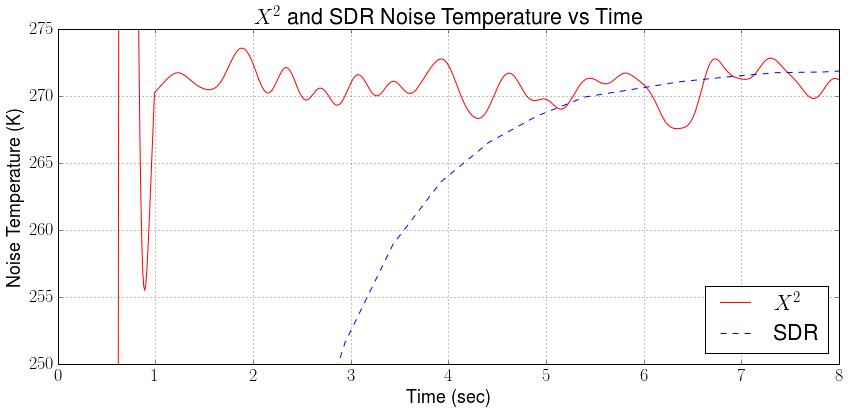

In [30]:
#g = g[(4*2):]
#y = y[(4*2):]
fig = plt.figure(figsize=(14,6), dpi=300)
plot(w,x2_calib,'r',label='$X^2$')
plot(timedata,sdrdata,'b--',label='SDR')
xlabel('Time (sec)')
ylabel('Noise Temperature (K)')
title('$X^2$ and SDR Noise Temperature vs Time')
axis([0, 8, 250, 275])
grid(True)
legend(loc='lower right')
fig.savefig("x2_SDR_shift.pdf", dpi=300)
fig.savefig("x2_SDR_shift.png", dpi=300)

##Application - Soil Moisture Reading
One application of radiometers is with Soil Moisture readings.  All items naturally emit RF and the amount of RF emitted from the soil varies depending on how wet or dry it is.  The drier the soil the "brighter" it is or we often say it has a warmer noise temperature.  Wet soil then has a cooler or darker noise temperature.  

One way for us to show this is with a waterfall display in the software defined radio.  GNURadio allows us to have a waterfall display and we can set the range of the power readings it sees.  This is not a perfect system as it is not running through an integrator, however we can see a change in colors as we change from Ice water to LN2.  There is a limit that GNURadio allowed for the dB range in the waterfall display.  If a smaller range can be defined, the color change should be even more pronounced than what is shown in the pictures below.
<img src="LN2_waterfall.png" alt="SDR" width=80%>

In our experiments we did not have an actual antenna attached to the radiometer.   Therefore there was no way for us get actual data of different types of soils.  However, we can somewhat fake this by saying that our LN2 is very dry soil or 0% and our ice water is 100% soil moisture.  

Let's look at two screen shots of the waterfall display side by side.

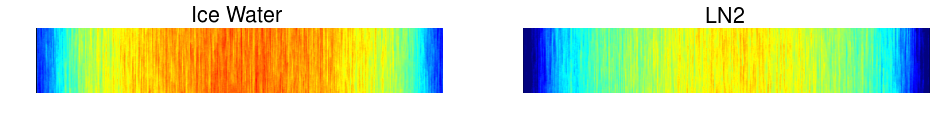

In [31]:
plt.rcParams['figure.figsize'] = (16,4)
matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})
#plt.tight_layout()
fig, (ax_a, ax_b) = plt.subplots(1, 2)
#fig, ax2 = plt.subplots(figsize=(18,3), dpi=300)
img=mpimg.imread('icewater_waterfall_crop.png')
img2=mpimg.imread('LN2_waterfall_crop.png')
ax_a.axis('off')
ax_a.imshow(img)
ax_b.imshow(img2);
ax_b.axis('off')
ax_a.set_title('Ice Water')
ax_b.set_title('LN2')
#imgplot = plt.imshow(img)
#imgplot = ax2.imshow(img2)
#plt.axis('off')
#colorbar()
fig.savefig("waterfall_side.pdf", dpi=300)
fig.savefig("waterfall_side.png", dpi=300)

We can see in the two images above that left image is "warmer" than the right.  The left image is the waterfall display from when it was it ice water.  The image on the right is when the matched load was in LN2.  This is one method to look at, in real time, the overall noise temperature of the system.

It should also be noted that that the waterfall display uses color to show power, the x-axis to show frequency, and the y-axis to show time.  Since this display is in real time, time is always changing, and hence why this is referred to as a waterfall display, as it looks like a waterfall when used.  However, since we have frequency information, this will also show us any interferring signal as well.  The signal will show up as a very "hot" spot on the waterfall and can let us know visually, where the interferring signal is.  

Another method for looking at soil moisture both in terms as noise temperature and as a percentage is to map the noise temperature to a percentage and then graph the result.  In the code below we begin by mapping our noise temperature values from 0 to 1.  We can then plot these and add two y-axeses to our graph.  Finally we use colorline to colorize the line to further show the difference in noise temperature.

In [32]:
h = g[:(620*2)]
i = y[:(620*2):]

In [33]:
m = interp1d([72,280],[0,1])
j = m(h)

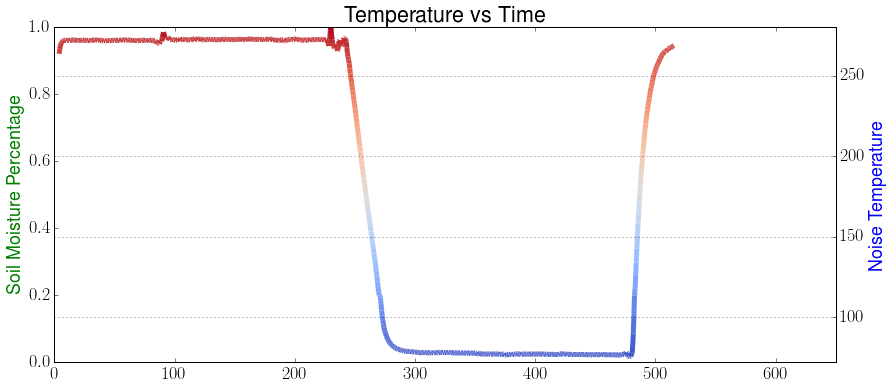

In [34]:
fig, ax1 = plt.subplots(figsize=(14,6), dpi=300)
matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})
ax2 = ax1.twinx()

ax1.set_ylabel('Soil Moisture Percentage', color='g')
ax2.set_ylabel('Noise Temperature', color='b')
#plot(y,g)
colorline(i,h,j,linewidth=5,cmap='coolwarm')
colorline(i,j,j,cmap='coolwarm')
xlabel('Time')
#ylabel('Noise Temperature (K)')
title('Temperature vs Time')
grid(True)
axis([0, 650, 72, 280])
fig.savefig("sdr_soilmoisture.pdf", dpi=300)
fig.savefig("sdr_soilmoisture.png", dpi=300)

---
## Sensitivity
Earlier, we calculated the $NE\Delta T$ and figured out what we should expect for this value.  Our change in the equivelent noise temperature, $NE\Delta T$, can also be thought as the standard deviation of the data.  To look at this, we will first zoom in to a section of the graph, let's look at when the matched load was in LN2, which is a very stable temperature point.  We do this by trimming the data to just the points we want, in our case we will look between 350 to 425 seconds.

In [35]:
g = g[(350*2):]
g = g[:(425*.5)]
y = y[(350*2):]
y = y[:(425*.5)]

C:\Users\Matthew\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
C:\Users\Matthew\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


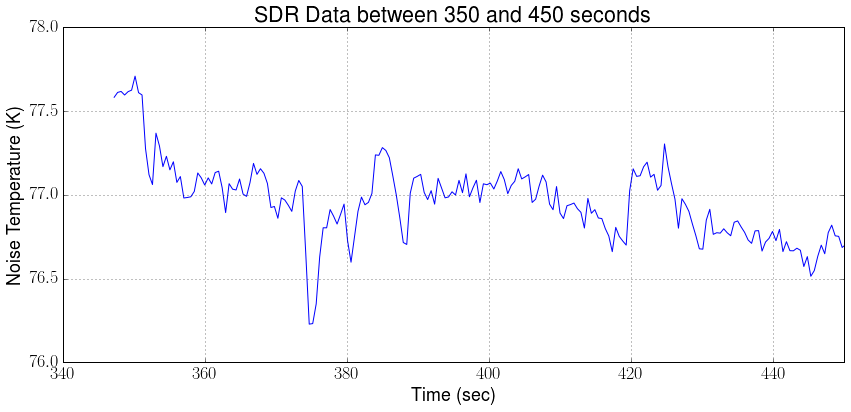

In [36]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,g)
xlabel('Time (sec)')
ylabel('Noise Temperature (K)')
title('SDR Data between 350 and 450 seconds')
grid(True)
axis([340, 450, 76, 78])
fig.savefig("SDR_Zoom.pdf", dpi=300)
fig.savefig("SDR_Zoom.png", dpi=300)

Now let's do a standard deviation on this data.  We will also do a polyfit to the line as well.

In [37]:
stdsdr = numpy.std(g)
print stdsdr
p = numpy.polyfit(y,g,2)
print p

0.234595
[  1.43663713e-05  -1.59815666e-02   8.10392666e+01]


Our standard deviation is .23 Kelvin.  We calculated our $NE\Delta T$ to be about .09 Kelvin.  Again, some error is to be expected as our $NE\Delta T$ equation is a bit simplified.  However, .23 Kelvin is still well within our desired $NE\Delta T$ of 1 Kelvin, so our experimental results show that the performance of this radiometer is accetable.  

Let's now plot our data with our polynominal fitted line.  We will then also plot the standard deviation as well.

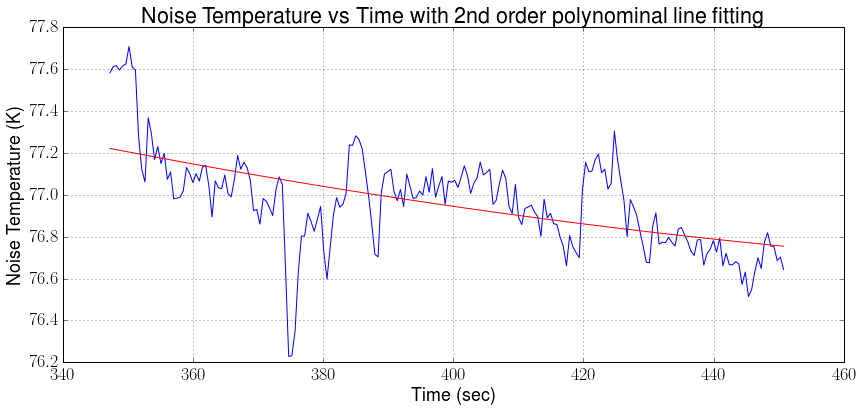

In [38]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,g)
plot(y,p[0]*y*y+p[1]*y+p[2],'r-')
xlabel('Time (sec)')
ylabel('Noise Temperature (K)')
title('Noise Temperature vs Time with 2nd order polynominal line fitting')
grid(True)
fig.savefig("std_dev_fitline.pdf", dpi=300)
fig.savefig("std_dev_fitline.png", dpi=300)

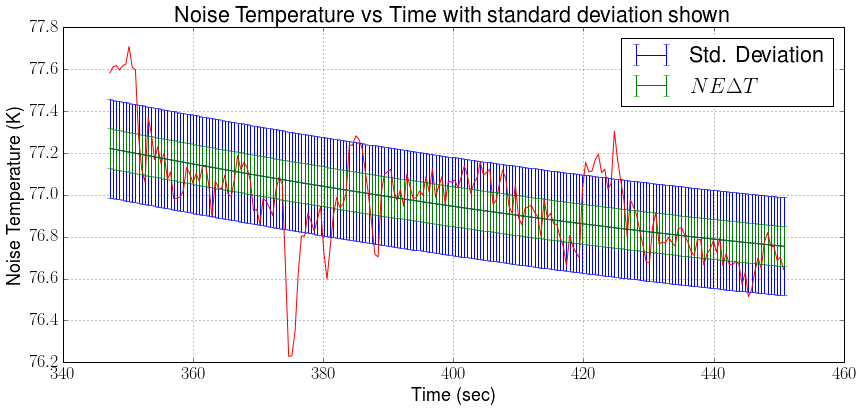

In [39]:
fig = plt.figure(figsize=(14,6), dpi=300)
b = p[0]*y*y+p[1]*y+p[2]
plot(y,g,'r-')
errorbar(y,b,stdsdr,label='Std. Deviation')
errorbar(y,b,NEAT_SDR,ecolor='g', label='$NE\Delta T$')
xlabel('Time (sec)')
ylabel('Noise Temperature (K)')
title('Noise Temperature vs Time with standard deviation shown')
grid(True)
legend(loc='upper right')
fig.savefig("std_dev_errbar.pdf", dpi=300)
fig.savefig("std_dev_errbar.png", dpi=300)

In conclusion, both the Software Defined Radio configured as a radiometer and the square-law detector performed as expected.  We were able to record total power information, calibrate them to our known temperatures, and then look at the data.  The $NE\Delta T$ of the software defined radio was calculated and also determined from our graphs of the data.  Both of those values were reasonable and were below our desired 1 K value.  